# Домашнее задание 4

В этом задании мы:
1. Построим классификатор датасета CIFAR с помощью обычных нейросетей и CNN.
2. Поработаем с аугментациями и добьемся большего качества с их помощью.
3. Попрактикуемся с техникой fine-tuning: возьмем готовый MobileNet и дообучим последний слой под нашу задачу.

## Классификация: CNN против обычных сетей

В первой части задания мы повторим то, что проделывалось на лекции.
Но на этот раз будем учить сети до победного, пока их качество не перестанет улучшаться - и сравним результаты.

Также в конце оценим число параметров в каждой сети, чтобы сравнить эффективность CNN и FC при работе с изображениями.

Воспользуемся датасетом CIFAR.

In [1]:
from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor

train_dataset = CIFAR10(root="./data", train=True, download=True, transform=ToTensor())
test_dataset = CIFAR10(root="./data", train=False, download=True, transform=ToTensor())

100%|██████████| 170M/170M [00:05<00:00, 31.3MB/s]


### Задание №1

Создайте два объекта `DataLoader` и сохраните их в переменные `train_loader` и `test_loader` (для тренировочной и тестовой выборки соответственно).

Используйте размер батча 256.

In [2]:
from torch.utils.data import random_split

# Разбивка Трейна на трейн с валидационный
train_size = int(0.9 * len(train_dataset)) #int- целое число. Надо чтобы было целое чтобы потом сплит работал
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))


In [3]:
from torch.utils.data import DataLoader


generator = torch.Generator().manual_seed(42)

train_loader = DataLoader(
    train_dataset,
    batch_size=256,
    # перемешать данные или нет
    shuffle=True,
    # если перемешать - озаботьтесь воспроизводимостью
    generator=generator,
    # В последнем батче может не набраться 32 элемента.
    # Этот флаг говорит, убрать такой батч или оставить.
    drop_last=True,
)


test_loader = DataLoader(
    test_dataset,
    batch_size=256,
    # перемешать данные или нет
    shuffle=False,
    # если перемешать - озаботьтесь воспроизводимостью
    generator=generator,
    # В последнем батче может не набраться 32 элемента.
    # Этот флаг говорит, убрать такой батч или оставить.
    drop_last=False,
)


val_loader = DataLoader(
    val_dataset,
    batch_size=256,
    # перемешать данные или нет
    shuffle=False,
    # если перемешать - озаботьтесь воспроизводимостью
    generator=generator,
    # В последнем батче может не набраться 32 элемента.
    # Этот флаг говорит, убрать такой батч или оставить.
    drop_last=False,
)

### Задание №2

Обучите полносвязную сеть для классификации CIFAR.

Достаточно 3 блоков "Linear + ReLU".
Ваша задача - вывести accuracy на _тестовой выборке_ на плато.
Т.е. нужно обучить сеть настолько долго, чтобы увидеть, как ее качество перестает расти с ростом числа эпох.
Для этого попробуйте подвигать `lr` и `num_epochs`.


Сдайте в ЛМС предельный accuracy, который может достичь полносвязная сеть.

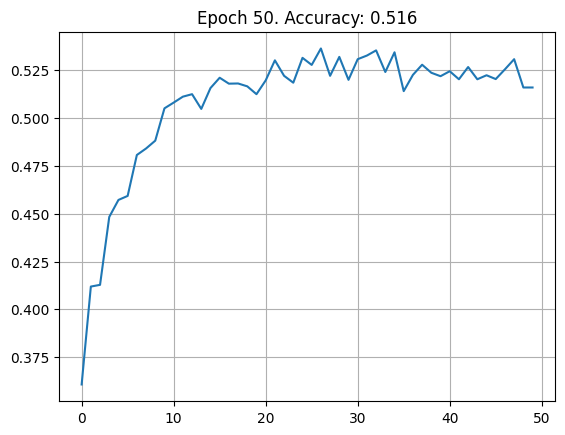

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output


@dataclass
class TrainConfig:
    lr: float
    num_epochs: int


def plot_accuracy(epoch: int, values: list[float]):
    # эта хрень намекает что надо взять значение accuracy добавить его в список validation_accuracy и передать его в плот
    # а ай в этом случае это в циклах по эпохам. То есть график надо вызывать в конце цикла эпох
    """Пример:
    >>> acc.append(validation_accuracy)
    >>> plot(i + 1, validation_accuracy)
    """
    clear_output(True)
    # заголовок графика эпохи
    plt.title("Epoch %s. Accuracy: %s" % (epoch, values[-1]))
    # когда мы валуес передаем, там значения акураси они будут строиться по y слева направо
    plt.plot(values)
    plt.grid()
    plt.show()


# ТРЕНИРОВОЧНАЯ ПЕТЛЯ
def train_loop(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    config: TrainConfig,
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
):
    # Перенос модели на GPU, если доступен
    model = model.to(device)
    # создаем список чтобы потом строить график
    val_acc = []

    # ЦИКЛ (запуск первой эпохи) в этой эпохе 1 трейнлоадер, в который выдает по 1 бытчу с 256 картинками (далее цикл)
    for i in range(config.num_epochs):
        model.train()  # Переключение в режим обучения

        # Внутри каждой эпохи один трейнлоадер в котором есть 256 картинок (значит батчей примерно 195 так как 50000/256)
        # В данном случае X_batch это 256 картинок как мы указали в train_loader
        #  этот цикл проходит ВСЕ 50 000 картинок — батч за батчом
        for X_batch, y_batch in train_loader:
            # Переносим батч из 256 картинок и меток на то же устройство, где находится модель (обычно GPU)
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Обнуление градиентов
            # так как мы считаем градиенты только для текущего батча в котором 256 картинов (так как это цикл)
            # и мы обновляем веса после КАЖДОГО батча из 256 картинов
            # Обнуляем старые градиенты перед тем, как начать вычисление новых.
            # Иначе градиенты накапливались бы от предыдущих батчей — это сломает обучение.
            optimizer.zero_grad()

            # Прогоняем текущий батч из 256 изображений через модель.
            # outputs — это тензор формы [256, 10]: предсказания для каждого изображения по 10 классам.
            outputs = model(X_batch)

            # Расчёт потерь по батчу из 256 картинок (в сравнении с правильными ответами y_batch)
            # loss — одно число (скаляр).
            loss = F.cross_entropy(outputs, y_batch)

            # Вычисляем градиенты ошибки по всем параметрам модели.
            # Только для этого батча из 256 картинок.
            loss.backward()  # Обратное распространение ошибки

            # Обновление параметров модели по рассчитанным градиентом
            # В данном случае у нас адам
            optimizer.step()

# =================
        # Валидация НА ДАННОМ ЭТАПЕ МЫ ПОЛНОСТЬЮ ПРОГНАЛИ ВСЕ КАРТИНКИ и обновили веса по ним (это была одна эпоха)
        model.eval()  # Переключение в режим валидации
        total_val_acc = 0 #нужно далее для расчетов
        total_val_samples = 0 # также для формулы

        with torch.no_grad(): # Всё, что находится внутри этого блока, будет выполняться без расчёта и хранения градиентов.
            for X_batch, y_batch in val_loader: # валидационный лоадер
                # Перенос батча на GPU
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                # Получение предсказаний модели по X через валидационный батч из валидационного лоадера
                # outputs — это тензор формы [256, 10]: предсказания для каждого изображения по 10 классам.
                val_outputs = model(X_batch)

                # Накопление статистики
                total_val_acc += (val_outputs.argmax(1) == y_batch).sum().item()
                # total_val_acc( который 0) + (берется индекс макс значения из val_outputs ЕСЛИ он равен y_batch тогда TRUE) -> СУММА TRUE в виде числа

                # во второй счетчик накапливается количество строк (предсказаний) в батче вообще
                total_val_samples += X_batch.size(0)


        # Расчёт средней потери и точности на валидационном наборе
        # У нас вверху был список val_acc (мы находимся все ещё внутри первой эпохи)
        # добавляем в список 1 значение акураси на валидационной выборке
        val_acc.append(total_val_acc / total_val_samples)

        # Вызываем функцию plot_accuracy
        # Передаём:
        # - номер текущей эпохи (i + 1), потому что i начинается с 0
        # - список значений accuracy на валидации (val_acc), накопленных за все эпохи
        plot_accuracy(i + 1, val_acc)
###### ЭПОХА ЗАКОНЧЕНА -начало новой


class SimpleFCNModel(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Flatten(), # этот слой передает многомерный тензор(картинку) в длинный вектор
            nn.Linear(3 * 32 * 32, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        return self.fc(x)


torch.manual_seed(987)
params = TrainConfig(lr=1e-3, num_epochs=50)
model = SimpleFCNModel()
optimizer = torch.optim.Adam(model.parameters(), lr=params.lr)
train_loop(model, train_loader, test_loader, optimizer, params)
# Около 0.55 должно выйти

In [ ]:
def report_parameters(model: nn.Module):
    print(
        "Суммарное количество параметров:",
        sum(p.nelement() for p in model.parameters()),
    )
    print(
        "Суммарный размер (Мб) параметров:",
        sum(
            parameter.nelement() * parameter.element_size()
            for parameter in model.parameters()
        )
        / 1024**2,
    )

In [ ]:
report_parameters(model)

### Задание №3

Теперь постройте и обучите CNN сеть.
Опять же, не используйте глубокую сеть: мы хотим иметь схожее количество параметров для сравнения.

Достаточно будет трех блоков "Conv + ReLU + MaxPool".

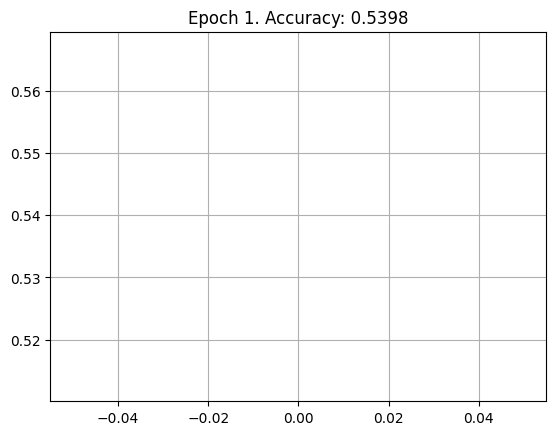

KeyboardInterrupt: 

In [6]:
from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor


import albumentations as A


transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.Normalize(...),
    ToTensorV2()
])



train_dataset = CIFAR10(root="./data", train=True, download=True, transform=ToTensor())
test_dataset = CIFAR10(root="./data", train=False, download=True, transform=ToTensor())




from torch.utils.data import random_split

# Разбивка Трейна на трейн с валидационный
train_size = int(0.9 * len(train_dataset)) #int- целое число. Надо чтобы было целое чтобы потом сплит работал
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))




from torch.utils.data import DataLoader


generator = torch.Generator().manual_seed(42)

train_loader = DataLoader(
    train_dataset,
    batch_size=256,
    # перемешать данные или нет
    shuffle=True,
    # если перемешать - озаботьтесь воспроизводимостью
    generator=generator,
    # В последнем батче может не набраться 32 элемента.
    # Этот флаг говорит, убрать такой батч или оставить.
    drop_last=True,
)


test_loader = DataLoader(
    test_dataset,
    batch_size=256,
    # перемешать данные или нет
    shuffle=False,
    # если перемешать - озаботьтесь воспроизводимостью
    generator=generator,
    # В последнем батче может не набраться 32 элемента.
    # Этот флаг говорит, убрать такой батч или оставить.
    drop_last=False,
)


val_loader = DataLoader(
    val_dataset,
    batch_size=256,
    # перемешать данные или нет
    shuffle=False,
    # если перемешать - озаботьтесь воспроизводимостью
    generator=generator,
    # В последнем батче может не набраться 32 элемента.
    # Этот флаг говорит, убрать такой батч или оставить.
    drop_last=False,
)









import matplotlib.pyplot as plt
# from IPython.display import clear_output


@dataclass
class TrainConfig:
    lr: float
    num_epochs: int


# def plot_accuracy(epoch: int, values: list[float]):
    # эта хрень намекает что надо взять значение accuracy добавить его в список validation_accuracy и передать его в плот
    # а ай в этом случае это в циклах по эпохам. То есть график надо вызывать в конце цикла эпох
    """Пример:
    >>> acc.append(validation_accuracy)
    >>> plot(i + 1, validation_accuracy)
    """
    clear_output(True)
    # заголовок графика эпохи
    plt.title("Epoch %s. Accuracy: %s" % (epoch, values[-1]))
    # когда мы валуес передаем, там значения акураси они будут строиться по y слева направо
    plt.plot(values)
    plt.grid()
    plt.show()


# ТРЕНИРОВОЧНАЯ ПЕТЛЯ
def train_loop(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    config: TrainConfig,
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
):
    # Перенос модели на GPU, если доступен
    model = model.to(device)
    # создаем список чтобы потом строить график
    val_acc = []

    # ЦИКЛ (запуск первой эпохи) в этой эпохе 1 трейнлоадер, в который выдает по 1 бытчу с 256 картинками (далее цикл)
    for i in range(config.num_epochs):
        model.train()  # Переключение в режим обучения

        # Внутри каждой эпохи один трейнлоадер в котором есть 256 картинок (значит батчей примерно 195 так как 50000/256)
        # В данном случае X_batch это 256 картинок как мы указали в train_loader
        #  этот цикл проходит ВСЕ 50 000 картинок — батч за батчом
        for X_batch, y_batch in train_loader:
            # Переносим батч из 256 картинок и меток на то же устройство, где находится модель (обычно GPU)
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Обнуление градиентов
            # так как мы считаем градиенты только для текущего батча в котором 256 картинов (так как это цикл)
            # и мы обновляем веса после КАЖДОГО батча из 256 картинов
            # Обнуляем старые градиенты перед тем, как начать вычисление новых.
            # Иначе градиенты накапливались бы от предыдущих батчей — это сломает обучение.
            optimizer.zero_grad()

            # Прогоняем текущий батч из 256 изображений через модель.
            # outputs — это тензор формы [256, 10]: предсказания для каждого изображения по 10 классам.
            outputs = model(X_batch)

            # Расчёт потерь по батчу из 256 картинок (в сравнении с правильными ответами y_batch)
            # loss — одно число (скаляр).
            loss = F.cross_entropy(outputs, y_batch)

            # Вычисляем градиенты ошибки по всем параметрам модели.
            # Только для этого батча из 256 картинок.
            loss.backward()  # Обратное распространение ошибки

            # Обновление параметров модели по рассчитанным градиентом
            # В данном случае у нас адам
            optimizer.step()

# =================
        # Валидация НА ДАННОМ ЭТАПЕ МЫ ПОЛНОСТЬЮ ПРОГНАЛИ ВСЕ КАРТИНКИ и обновили веса по ним (это была одна эпоха)
        model.eval()  # Переключение в режим валидации
        total_val_acc = 0 #нужно далее для расчетов
        total_val_samples = 0 # также для формулы

        with torch.no_grad(): # Всё, что находится внутри этого блока, будет выполняться без расчёта и хранения градиентов.
            for X_batch, y_batch in val_loader: # валидационный лоадер
                # Перенос батча на GPU
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                # Получение предсказаний модели по X через валидационный батч из валидационного лоадера
                # outputs — это тензор формы [256, 10]: предсказания для каждого изображения по 10 классам.
                val_outputs = model(X_batch)

                # Накопление статистики
                total_val_acc += (val_outputs.argmax(1) == y_batch).sum().item()
                # total_val_acc( который 0) + (берется индекс макс значения из val_outputs ЕСЛИ он равен y_batch тогда TRUE) -> СУММА TRUE в виде числа

                # во второй счетчик накапливается количество строк (предсказаний) в батче вообще
                total_val_samples += X_batch.size(0)


        # Расчёт средней потери и точности на валидационном наборе
        # У нас вверху был список val_acc (мы находимся все ещё внутри первой эпохи)
        # добавляем в список 1 значение акураси на валидационной выборке
        val_acc.append(total_val_acc / total_val_samples)

        # Вызываем функцию plot_accuracy
        # Передаём:
        # - номер текущей эпохи (i + 1), потому что i начинается с 0
        # - список значений accuracy на валидации (val_acc), накопленных за все эпохи
        # plot_accuracy(i + 1, val_acc)
###### ЭПОХА ЗАКОНЧЕНА -начало новой


class SimpleFCNModel(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.fc = nn.Sequential(
            # на примем 256, 3, 32, 32
             nn.Conv2d(
                in_channels=3, kernel_size=3, out_channels=64
            ),
            # выход 256, 64, 30, 30 (он параллелит потоки и весь батч проходит сразу)
            # зануление значений меньше 0
            nn.ReLU(),
            # из 4 клеток выбираем самое большое значение (ужимка в 2 раза)
            nn.MaxPool2d(kernel_size=2),
            # выход 256 * 64 * 15 * 15 (3 последний превращаются в один тензор 14400)

            nn.Flatten(), # этот слой передает многомерный тензор(картинку там 64 канала) в длинный вектор
            nn.Linear(64 * 15 * 15, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
            # nn.ReLU(),
            # nn.Linear(256, 128),
            # nn.ReLU(),
            # nn.Linear(128, num_classes),
        )

    # def forward(self, x):
    #     return self.fc(x)
    def forward(self, x):
        x = self.fc(x)
        # print("shape после fc:", x.shape)
        return x



torch.manual_seed(987)
params = TrainConfig(lr=1e-3, num_epochs=50)
model = SimpleFCNModel()
optimizer = torch.optim.Adam(model.parameters(), lr=params.lr)
train_loop(model, train_loader, test_loader, optimizer, params)
# Около 0.55 должно выйти

In [ ]:
report_parameters(model)

Обратите внимание на качество и на число параметров.
Качество получается выше, а число параметров - на порядок меньше.

Делаем вывод, что CNN позволяют выбивать лучшее качество, чем обычные сети, и при меньшем числе параметров.

Но CNN - не единственный способ улучшить качество при работе с картинками.

### Задание №4
Реализуйте следующие аугментации:
1. Горизонтальное отражение (Horizontal Flip) с вероятностью применения 30%
2. Вращение на угол (Rotate), близкий к 30 градусам, с вероятностью применения около 30%.
3. Random Resized Crop - тут выберите нужные параметры самостоятельно.
4. Normalize. Нормализовать нужно вдоль трех осей изображения. Среднее и std подсчитайте самостоятельно, используя `train_dataset` (в подсчет статистик _нельзя_ включать `test_dataset`).

Используйте библиотеку `albumentations`.
Не забудьте, что `albumentations` работает с numpy-массивами.
Придется перегонять данные из pytorch в numpy-массивы и обратно:

```python
np_array = tensor.numpy()
tensor_back = torch.from_numpy(np_array)
```

Сохраните аугментации в переменную `transforms` и сдайте свой код в ЛМС.

<details>
<summary>Как ваш код будет проверяться</summary>

```python
import albumentations as A

# <Ваш код здесь>

# Затем проверки на переменную transforms
assert some_check(transforms)
assert another_check(transforms)
```
</details>

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

image_size = 32
transforms = ...

In [ ]:
import albumentations as A

image_size = 32

transforms = A.Compose([
    A.HorizontalFlip(p=0.3),
    A.Rotate(limit=30, p=0.3),
    A.RandomResizedCrop(image_size, image_size, scale=(0.8, 1.0), p=1.0),
    A.Normalize(mean=mean, std=std),
    ToTensorV2(),
])

# Затем проверки на переменную transforms
assert some_check(transforms)
assert another_check(transforms)

## Аугментации
Зачастую аугментации помогают увеличить качество модели.
Объясняется это так: аугментация изображений обогащает датасет новыми картинками, сгенерированными из существующих.
Переобучения не происходит, потому что мы не просто дублируем изображения, а немного изменяем их.
### Задание №5

Обучите CNN с использованием аугментаций.
Как и в прошлых заданиях, держите обучение до конца - пока loss не выйдет на плато.

Ваша задача - получить accuracy выше 76%.
Сдайте в ЛМС:
- код класса модели. Класс должен называться `SimpleCNNModel`;
- .pt файл с обученной моделью;

Аугментации улучшили качество.

Заметьте, что нормализацию можно было бы применить и в прошлом пункте, чтобы более честно оценить, какой прирост дали развороты и вращения изображения.
Советуем самостоятельно провести эксперимент и увидеть различия.

<details>
    <summary>Какие результаты ожидать</summary>
    У авторов получилось около 73% accuracy при использовании только лишь нормализации. При добавлении остальных аугментаций качество было еще выше.
</details>

## Transfer learning
### Задание №6
Transfer learning состоит в том, чтобы взять готовую сеть и дообучить небольшую ее часть.
В этом задании мы будем учить FC слой в конце MobileNet.

Загрузите предварительно обученную модель из серии `MobileNet`, используйте `MobileNet_V3_large`.

Поменяйте ее последний слой (классификатор) на один линейный слой.
Обучите все это дело, меняя **только** параметры своего слоя (подумайте, что передавать в оптимизатор).
Сохраните обученный слой (и только его) в `model_finetune.pt`.

Сдайте в ЛМС .pt файл и код, создающий вашу модель в переменную `model_finetune`.
Чтобы сдать это задание, достаточно набрать accuracy > 40%.

In [ ]:
print(
    "Суммарное количество параметров:",
    sum(p.nelement() for p in trainable_params),
)
print(
    "Суммарный размер (Мб) параметров:",
    sum(
        parameter.nelement() * parameter.element_size()
        for parameter in trainable_params
    )
    / 1024**2,
)

Качество, возможно, просело, зато учим намного меньше параметров.

## Задание №7
Возьмите предпоследний слой вашей CNN модели (тот, что до классификатора).
Этот слой выдает вектора.

Возьмите любой объект из класса 0, подсчитайте его косинусную схождесть со всеми остальными объектами из класса 0, усредните.
Затем подсчитайте то же число, только против всех объектов из класса 1, тоже усредните.
Отправьте в ЛМС два числа, разделенные запятой. Например, "1, 1".

In [ ]:
...

#### Небольшой бонус
Эмбеддинги можно визуализировать, используя t-SNE.
Посмотрите, что получается, попробуйте объяснить картину.

Если модель достаточно качественная, то схожие классы должны собираться в одну кучку, при этом у кучек должны прослеживаться границы.
Конечно же, не забывайте про выбросы.

In [ ]:
from sklearn.manifold import TSNE

result = torch.empty((0, 2048))
labels = []
with torch.no_grad():
    embedding_model.cpu()
    for x_batch, y_batch in test_loader_augs:
        embedding = embedding_model(x_batch).flatten(1)
        embedding /= embedding.norm()
        result = torch.concat((result, embedding))
        labels.extend(y_batch.tolist())

tsne = TSNE(random_state=42)
plot_data = tsne.fit_transform(result.numpy())

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
scatter = ax.scatter(
    plot_data[:, 0],
    plot_data[:, 1],
    c=labels,
    cmap="viridis",
    edgecolor="k",
    s=20,
    alpha=1,
)
plt.colorbar(scatter)